In [4]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split, KFold

import helper

In this notebook I use transfer learning with a pretrained resnet18 model to try how pleasant or unpleasant a persons experience of 20 second videos.  As a first pass I do this with static summary images (hence resnet18) of the videos.  In psychology and neuroscience a common assumption is that images reliably induce a uniform affective (pleasant or unpleasant states) across all participants and presentations.  Previous work has shown DNNs can reliably predict normative (average across many people) affective ratings from images, yet to my knowledge no work has examined whether DNNs can predict subjective (a single person in a single viewing) affective ratings. As a first pass I treat the affective ratings - although ordinal in nature as a classification problem.


In [2]:
#loading training images and participant rating info
training_image_frames = 'BBOE/VideoInformation/SummaryFrames/*/*/*.jpg'
list_of_file_names = glob.glob(training_image_frames)

#only participants with complete data are included.  Data collection is ongoing 
pars =['001','002','003','005','006']
cleaned_df_dict = {}
for par in pars:
    par_list_dfs =[]
    log_file_paths = f'BBOE/Behavioral/Participant_{par}/*/NSFScannerTask*'
    par_files = glob.glob(log_file_paths)
    for par_file in par_files:
        par_list_dfs.append(pd.read_csv(par_file,delim_whitespace=True))
    par_df = pd.concat(par_list_dfs)
    #align video ratings and summary frames
    clean_df = helper.CleanUpDataFrame(par_df,list_of_file_names)
    cleaned_df_dict[par]= clean_df

In [ ]:
# train pretrained network to predict affective ratings
num_epochs=40
random_state_int = 5
n_splits = 5 
n_classes = 3
learning_rate = 1e-5
train_batch_size=32

device = "cuda" if torch.cuda.is_available() else "cpu"

if n_classes==3:
    target_transform = helper.three_class_problem
    
for par in cleaned_df_dict.keys():
    val_image_df=cleaned_df_dict[par]
    k_fold = KFold(n_splits=n_splits,random_state=5,shuffle=True)
    splitter = k_fold.split(val_image_df.image_paths.values,val_image_df.valence_rating.values)
    
    for idx,fold in enumerate(splitter):
        train_idx,test_idx=fold
    
        transform_list = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])
        
        test_dataset = helper.CustomImageDataset(
            val_image_df.valence_rating.values[test_idx],
            val_image_df.image_paths.values[test_idx],
            transform=transform_list,
            target_transform=target_transform
        )
        train_dataset = helper.CustomImageDataset(
            val_image_df.valence_rating.values[train_idx],
            val_image_df.image_paths.values[train_idx],
            transform=transform_list,
            target_transform=target_transform
        )
    
        train_dataloader = DataLoader(train_dataset,batch_size=train_batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),shuffle=True)

        model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, n_classes)
        
#         for param in model_ft.parameters():
#             param.requires_grad = True

        model_ft.to(device)
        optimizer = optim.Adam(model_ft.parameters(),lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        epoch_avg_acc,test_acc = helper.TrainTestLoop(
            model_ft,
            optimizer,
            criterion,
            train_dataloader,
            test_dataloader,
            num_epochs,
            device
        )
        par_acc_df = pd.DataFrame({'epoch_val_acc':epoch_avg_acc,'epoch_test_acc':test_acc,'fold':[idx]*len(epoch_avg_acc)})
        par_acc_df.to_csv(f'transfer_image_learning_results/resnet18_{par}_Fold_{idx}_acc_ADAM_lastLayer_{n_classes}classproblem.csv')

Results for 5 participants across 3 sets of training hyper parameters are shown below.  Different participants are shown in different rows, the correspond to fine tuning all parameters in the network for a 5 way classification, fine tuning the just the final layer, and finetuning just the final layer for 3 way classification task in which the two levels of positive and negative are combined (3 classes: negative, neutral, positive).  Due to the limited number of samples in the datasets ~ 250 per person I used five fold cross validation.

We see across all folds the networks memorize and achieve high accuracy on the training data suggesting they're training correctly (green lines) and that they predict the validation data above chance (redlines are each fold, thick redline is average across five folds, thick black line is chance).  The absolute classification accuracy of all networks is relatively modest.  As a machine learning result this modest accuracy is disapointing however it is consistent with much psychological research suggesting that a person's affective state is governed by far more than just the visual stimuli they're presented with but interacts complex with current ones current context, and life history.

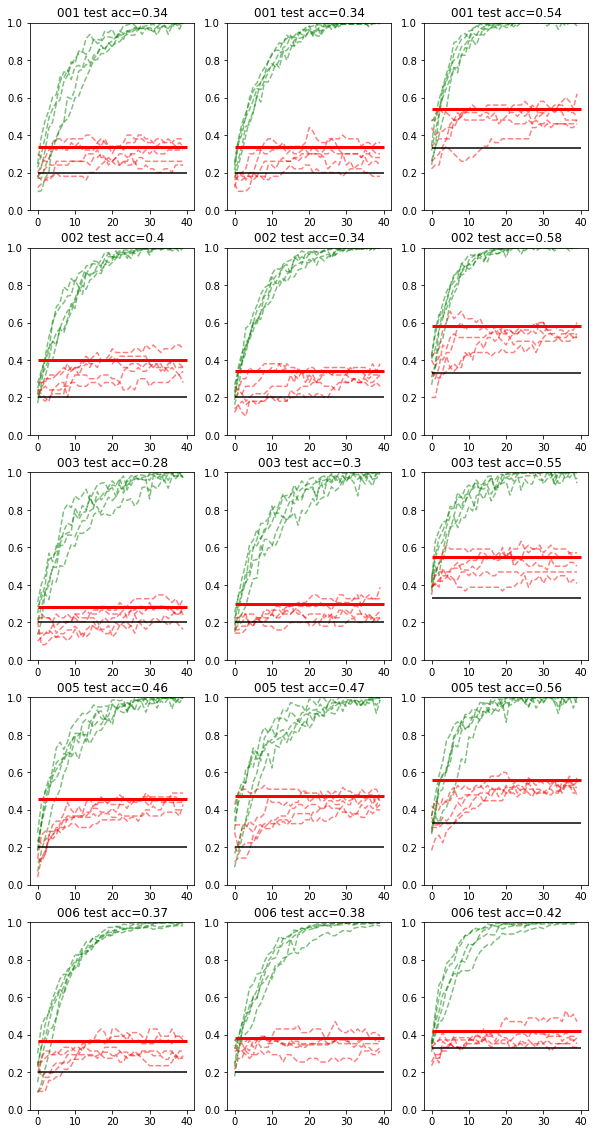

In [5]:
pars =['001','002','003','005','006']
hyper_param_list = ['allgradients','lastLayer','lastLayer_3classproblem']
fig, axs = plt.subplots(len(pars), len(hyper_param_list),figsize=(10,20))
acc_save_str = 'transfer_image_learning_results/resnet18_{}_Fold_*_acc_ADAM_{}.csv'
for hyperparam_idx,hyperparam in enumerate(hyper_param_list):
    for par_idx, par in enumerate(pars):
        acc_files = glob.glob(
            acc_save_str.format(par,hyperparam)
        )

        acc_fold_highest_acc_list = []
        for acc_file in acc_files:
            acc_df = pd.read_csv(acc_file)
            axs[par_idx,hyperparam_idx].plot(acc_df.epoch_test_acc,c='r',linestyle='--',alpha=.5)
            highest_acc_fold = acc_df['epoch_test_acc'].nlargest(3).mean()
            acc_fold_highest_acc_list.append(highest_acc_fold)
            axs[par_idx,hyperparam_idx].plot(acc_df.epoch_val_acc,c='g',alpha=.5,linestyle='--')
        mean_highest = np.mean(acc_fold_highest_acc_list)
        
        if hyperparam_idx<2:
            chance = .2
        else:
            chance =.33
        axs[par_idx,hyperparam_idx].hlines(chance,0,40,colors='black')
        axs[par_idx,hyperparam_idx].hlines(mean_highest,0,40,colors='r',lw=3)
        axs[par_idx,hyperparam_idx].set_title(
            par+f' test acc={round(mean_highest,2)}'
        )
        axs[par_idx,hyperparam_idx].set_ylim([0,1])